# Model Preliminaries

## 0. Configure Environment

In [1]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1 
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed. Restart the kernel to pick the new changes.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.0.1+cu118 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


Check if we can take advantage of PyTorch 2 optimizations

In [2]:
# Make sure we're using a NVIDIA GPU
GPU_SCORE = (0, 0)
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
  
  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_RTX_A4000
GPU capability score: (8, 6)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Fri Sep  1 21:19:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   35C    P8    17W / 140W |      3MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+------------

In [3]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (8, 6), enabling TensorFloat32 (TF32) computing (faster on new GPUs)


Do regular imports

In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.


In [5]:
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
RANDOM_SEED = 37

## 1. Get the data

### 1.1 Download the dataset

In [8]:
from pathlib import Path

url = "https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded"

# To access persistent storage in Paper space
root_storage = "/storage/"

data_path = Path(f"{root_storage}data/")
destination_path = "chest_xray_2017"
image_path = data_path / destination_path

In [38]:
from tqdm.auto import tqdm

import os
import shutil
import zipfile
import requests

if image_path.is_dir():
    print(f"[INFO] {image_path} exists. Skipping...")
else:
    print(f"[INFO] {image_path} not found. Creating...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download the dataset
    target_file = Path(destination_path + ".zip")

    print(f"[INFO] Downloading {target_file} from {url}...")

    with requests.get(url, stream=True) as r:
        # check header to get content length, in bytes
        total_length = int(r.headers.get("Content-Length"))

        # implement progress bar via tqdm
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc="") as raw:
            with open(data_path / target_file, "wb") as f:
                shutil.copyfileobj(raw, f)
    
    # Unzip the dataset
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...")
        zip_ref.extractall(image_path)
        
    os.remove(data_path / target_file)

[INFO] /storage/data/chest_xray_2017 exists. Skipping...


In [9]:
# !rm -rf /storage/data
!ls /storage/data

chest_xray_2017  chest_xray_2017_augmented


### 1.2 Organize the data
We want to split bacterial and viral pneumonia into different categories

In [10]:
# !ls /storage/data/chest_xray_2017/chest_xray/train/PNEUMONIA

In [9]:
dataset_dir = data_path / "chest_xray_2017/chest_xray"
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"
dataset_dir, train_dir, test_dir

(PosixPath('/storage/data/chest_xray_2017/chest_xray'),
 PosixPath('/storage/data/chest_xray_2017/chest_xray/train'),
 PosixPath('/storage/data/chest_xray_2017/chest_xray/test'))

In [11]:
sample_train_paths = list(train_dir.glob("PNEUMONIA/*.jpeg"))
print(f"[INFO] Sample train images (Count: {len(sample_train_paths)}): \n{sample_train_paths[:5]}\n")

virus_train_paths = list(train_dir.glob("PNEUMONIA/*virus*.jpeg"))
print(f"[INFO] Virus train images (Count: {len(virus_train_paths)}): \n{virus_train_paths[:5]}\n")

bacteria_train_paths = list(train_dir.glob("PNEUMONIA/*bacteria*.jpeg"))
print(f"[INFO] Bacteria train images (Count: {len(bacteria_train_paths)}): \n{bacteria_train_paths[:5]}\n")

[INFO] Sample train images (Count: 0): 
[]

[INFO] Virus train images (Count: 0): 
[]

[INFO] Bacteria train images (Count: 0): 
[]



In [21]:
# move bacteria and virus images to the paths we need
bacteria_train_dir = train_dir / "BACTERIAL_PNEUMONIA"
virus_train_dir = train_dir / "VIRAL_PNEUMONIA"

bacteria_train_dir.mkdir(parents=True, exist_ok=True)
virus_train_dir.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Copying images to {bacteria_train_dir}")
for src_path in tqdm(bacteria_train_paths):
    dest_path = bacteria_train_dir / os.path.basename(src_path)
    shutil.copyfile(src_path, dest_path)

print(f"[INFO] Copying images to {virus_train_dir}")
for src_path in tqdm(virus_train_paths):
    dest_path = virus_train_dir / os.path.basename(src_path)
    shutil.copyfile(src_path, dest_path)

[INFO] Copying images to /storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA


  0%|          | 0/2538 [00:00<?, ?it/s]

[INFO] Copying images to /storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA


  0%|          | 0/1345 [00:00<?, ?it/s]

Do the same for test datasets

In [22]:
sample_test_paths = list(test_dir.glob("PNEUMONIA/*.jpeg"))
print(f"[INFO] Sample test images (Count: {len(sample_test_paths)}): \n{sample_test_paths[:5]}\n")

virus_test_paths = list(test_dir.glob("PNEUMONIA/*virus*.jpeg"))
print(f"[INFO] Virus test images (Count: {len(virus_test_paths)}): \n{virus_test_paths[:2]}\n")

bacteria_test_paths = list(test_dir.glob("PNEUMONIA/*bacteria*.jpeg"))
print(f"[INFO] Bacteria test images (Count: {len(bacteria_test_paths)}): \n{bacteria_test_paths[:5]}\n")


# move bacteria and virus images to the paths we need
bacteria_test_dir = test_dir / "BACTERIAL_PNEUMONIA"
virus_test_dir = test_dir / "VIRAL_PNEUMONIA"

bacteria_test_dir.mkdir(parents=True, exist_ok=True)
virus_test_dir.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Copying images to {bacteria_test_dir}")
for src_path in tqdm(bacteria_test_paths):
    dest_path = bacteria_test_dir / os.path.basename(src_path)
    shutil.copyfile(src_path, dest_path)

print(f"[INFO] Copying images to {virus_test_dir}")
for src_path in tqdm(virus_test_paths):
    dest_path = virus_test_dir / os.path.basename(src_path)
    shutil.copyfile(src_path, dest_path)

[INFO] Sample test images (Count: 390): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person1656_virus_2862.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person1678_virus_2895.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person1660_virus_2869.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person174_bacteria_832.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg')]

[INFO] Virus test images (Count: 148): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person1656_virus_2862.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person1678_virus_2895.jpeg')]

[INFO] Bacteria test images (Count: 242): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person174_bacteria_832.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/PNEUMONIA/person158_bacteria_742.jpeg'),

  0%|          | 0/242 [00:00<?, ?it/s]

[INFO] Copying images to /storage/data/chest_xray_2017/chest_xray/test/VIRAL_PNEUMONIA


  0%|          | 0/148 [00:00<?, ?it/s]

In [23]:
# remove the PNEUMONIA directories
shutil.rmtree(test_dir / "PNEUMONIA")
shutil.rmtree(train_dir / "PNEUMONIA")

In [9]:
!ls /storage/data/chest_xray_2017/chest_xray/test/
!ls /storage/data/chest_xray_2017/chest_xray/train/

BACTERIAL_PNEUMONIA  NORMAL  VIRAL_PNEUMONIA
BACTERIAL_PNEUMONIA  NORMAL  VIRAL_PNEUMONIA


In [12]:
normal_train_paths = list(train_dir.glob("NORMAL/*.jpeg"))
print(f"[INFO] Normal train images (Count: {len(normal_train_paths)}): \n{normal_train_paths[:2]}\n")

virus_train_paths = list(train_dir.glob("VIRAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Virus train images (Count: {len(virus_train_paths)}): \n{virus_train_paths[:2]}\n")

bacteria_train_paths = list(train_dir.glob("BACTERIAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Bacteria train images (Count: {len(bacteria_train_paths)}): \n{bacteria_train_paths[:2]}\n")

[INFO] Normal train images (Count: 1349): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/NORMAL2-IM-1096-0001-0003.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/IM-0712-0001.jpeg')]

[INFO] Virus train images (Count: 1345): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person97_virus_181.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person936_virus_1598.jpeg')]

[INFO] Bacteria train images (Count: 2538): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person1670_bacteria_4425.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person54_bacteria_257.jpeg')]



In [13]:
normal_test_paths = list(test_dir.glob("NORMAL/*.jpeg"))
print(f"[INFO] Normal test images (Count: {len(normal_test_paths)}): \n{normal_test_paths[:2]}\n")

virus_test_paths = list(test_dir.glob("VIRAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Virus test images (Count: {len(virus_test_paths)}): \n{virus_test_paths[:2]}\n")

bacteria_test_paths = list(test_dir.glob("BACTERIAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Bacteria test images (Count: {len(bacteria_test_paths)}): \n{bacteria_test_paths[:2]}\n")

[INFO] Normal test images (Count: 234): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/NORMAL/NORMAL2-IM-0333-0001.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg')]

[INFO] Virus test images (Count: 148): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/VIRAL_PNEUMONIA/person1656_virus_2862.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/VIRAL_PNEUMONIA/person1678_virus_2895.jpeg')]

[INFO] Bacteria test images (Count: 242): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/BACTERIAL_PNEUMONIA/person174_bacteria_832.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/BACTERIAL_PNEUMONIA/person158_bacteria_742.jpeg')]



### 1.3 Preview sample images

Random image path: /storage/data/chest_xray_2017/chest_xray/test/VIRAL_PNEUMONIA/person1649_virus_2850.jpeg
Image class: VIRAL_PNEUMONIA
Image height: 920
Image width: 1360
Image shape: (920, 1360)


(-0.5, 1359.5, 919.5, -0.5)

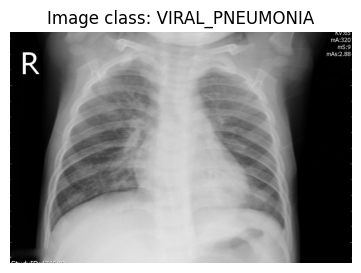

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import random
from PIL import Image

# Set seed
random.seed(37)

# Get all image paths
image_path_list = list(dataset_dir.glob("*/*/*.jpeg"))

# Get a random image's path
random_image_path = random.choice(image_path_list)

# Get image class from the path name (the name of the directory)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

img_as_array = np.asarray(img)
print(f"Image shape: {img_as_array.shape}")

plt.figure(figsize=(6, 3))
plt.imshow(img_as_array, cmap="gray")
plt.title(f"Image class: {image_class}")
plt.axis(False)

### 1.4 Increase the dataset size

#### 1.4.1 Preview data lengths

In [13]:
original_normal_train_paths = list(train_dir.glob("NORMAL/*.jpeg"))
print(f"[INFO] Original train images (Count: {len(original_normal_train_paths)}): \n{original_normal_train_paths[:2]}\n")

original_virus_train_paths = list(train_dir.glob("VIRAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Original virus train images (Count: {len(original_virus_train_paths)}): \n{original_virus_train_paths[:2]}\n")

original_bacteria_train_paths = list(train_dir.glob("BACTERIAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Original bacteria train images (Count: {len(original_bacteria_train_paths)}): \n{original_bacteria_train_paths[:2]}\n")

[INFO] Original train images (Count: 1349): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/NORMAL2-IM-1096-0001-0003.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/IM-0712-0001.jpeg')]

[INFO] Original virus train images (Count: 1345): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person97_virus_181.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person936_virus_1598.jpeg')]

[INFO] Original bacteria train images (Count: 2538): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person1670_bacteria_4425.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person54_bacteria_257.jpeg')]



In [14]:
original_normal_test_paths = list(test_dir.glob("NORMAL/*.jpeg"))
print(f"[INFO] Original normal test images (Count: {len(original_normal_test_paths)}): \n{original_normal_test_paths[:2]}\n")

original_virus_test_paths = list(test_dir.glob("VIRAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Original virus test images (Count: {len(original_virus_test_paths)}): \n{original_virus_test_paths[:2]}\n")

original_bacteria_test_paths = list(test_dir.glob("BACTERIAL_PNEUMONIA/*.jpeg"))
print(f"[INFO] Original bacteria test images (Count: {len(original_bacteria_test_paths)}): \n{original_bacteria_test_paths[:2]}\n")

[INFO] Original normal test images (Count: 234): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/NORMAL/NORMAL2-IM-0333-0001.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg')]

[INFO] Original virus test images (Count: 148): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/VIRAL_PNEUMONIA/person1656_virus_2862.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/VIRAL_PNEUMONIA/person1678_virus_2895.jpeg')]

[INFO] Original bacteria test images (Count: 242): 
[PosixPath('/storage/data/chest_xray_2017/chest_xray/test/BACTERIAL_PNEUMONIA/person174_bacteria_832.jpeg'), PosixPath('/storage/data/chest_xray_2017/chest_xray/test/BACTERIAL_PNEUMONIA/person158_bacteria_742.jpeg')]



Combine both train and test dataset paths

In [15]:
all_normal_paths = original_normal_train_paths + original_normal_test_paths
all_virus_paths = original_virus_train_paths + original_virus_test_paths
all_bacteria_paths = original_bacteria_train_paths + original_bacteria_test_paths
len(all_normal_paths), len(all_virus_paths), len(all_bacteria_paths)

(1583, 1493, 2780)

In [16]:
all_normal_paths[:2], all_virus_paths[:2], all_bacteria_paths[:2]

([PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/NORMAL2-IM-1096-0001-0003.jpeg'),
  PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/IM-0712-0001.jpeg')],
 [PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person97_virus_181.jpeg'),
  PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person936_virus_1598.jpeg')],
 [PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person1670_bacteria_4425.jpeg'),
  PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person54_bacteria_257.jpeg')])

In [31]:
import numpy as np
shuffled_normal_paths = np.array(all_normal_paths)
shuffled_virus_paths = np.array(all_virus_paths)
shuffled_bacteria_paths = np.array(all_bacteria_paths)

np.random.shuffle(shuffled_normal_paths)
np.random.shuffle(shuffled_virus_paths)
np.random.shuffle(shuffled_bacteria_paths)

shuffled_normal_paths = np.asarray(shuffled_normal_paths)
shuffled_virus_paths = np.asarray(shuffled_virus_paths)
shuffled_bacteria_paths = np.asarray(shuffled_bacteria_paths)

shuffled_normal_paths[:2], shuffled_virus_paths[:2], shuffled_bacteria_paths[:2]

(array([PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/IM-0509-0001-0001.jpeg'),
        PosixPath('/storage/data/chest_xray_2017/chest_xray/train/NORMAL/IM-0721-0001.jpeg')],
       dtype=object),
 array([PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person1160_virus_1947.jpeg'),
        PosixPath('/storage/data/chest_xray_2017/chest_xray/train/VIRAL_PNEUMONIA/person1293_virus_2219.jpeg')],
       dtype=object),
 array([PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person1841_bacteria_4708.jpeg'),
        PosixPath('/storage/data/chest_xray_2017/chest_xray/train/BACTERIAL_PNEUMONIA/person1481_bacteria_3866.jpeg')],
       dtype=object))

We have shuffled the dataset, now split it into test and train datasets

In [44]:
split_normal_train_paths, split_normal_test_paths = shuffled_normal_paths[400:], shuffled_normal_paths[:400]
split_virus_train_paths, split_virus_test_paths = shuffled_virus_paths[400:], shuffled_virus_paths[:400]
split_bacteria_train_paths, split_bacteria_test_paths = shuffled_bacteria_paths[400:], shuffled_bacteria_paths[:400]

print(f"Normal images: Train({len(split_normal_train_paths)}), Test({len(split_normal_test_paths)})")
print(f"Virus images: Train({len(split_virus_train_paths)}), Test({len(split_virus_test_paths)})")
print(f"Bacteria images: Train({len(split_bacteria_train_paths)}), Test({len(split_bacteria_test_paths)})")

Normal images: Train(1183), Test(400)
Virus images: Train(1093), Test(400)
Bacteria images: Train(2380), Test(400)


#### 1.4.2 Create the transformation pipeline
We will chain several `torchvision.transforms` augmentation steps

In [21]:
augmentation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.35),
    torchvision.transforms.RandomVerticalFlip(p=0.35),
    torchvision.transforms.RandomRotation(degrees=45, expand=True),
    torchvision.transforms.ToTensor()
])

Let's first see how this looks like

Random image path: /storage/data/chest_xray_2017/chest_xray/train/NORMAL/NORMAL2-IM-1156-0001.jpeg
Image class: NORMAL
Image height: 1148
Image width: 1592
Image shape: (1148, 1592)


(-0.5, 1857.5, 1563.5, -0.5)

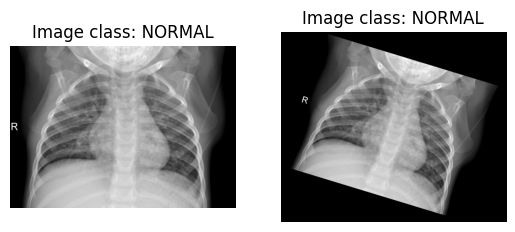

In [22]:
import random

# Set seed
random.seed(RANDOM_SEED)

# Get a random image's path
random_image_path = random.choice(original_normal_train_paths)

# Get image class from the path name (the name of the directory)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

transformed_image = augmentation_transforms(img)

img_as_array = np.asarray(img)
print(f"Image shape: {img_as_array.shape}")

fig, ax = plt.subplots(1, 2)
# plt.figure(figsize=(6, 3))
ax[0].imshow(img_as_array, cmap="gray")
ax[0].set_title(f"Image class: {image_class}")
ax[0].axis(False)

ax[1].imshow(transformed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
ax[1].set_title(f"Image class: {image_class}")
ax[1].axis(False)

In [23]:
# Save the sample to disk
torchvision.utils.save_image(transformed_image, fp=dataset_dir / "augmented_sample.jpeg")
!ls -lh "/storage/data/chest_xray_2017/chest_xray"

total 173K
-rw-r--r-- 1 root root 173K Aug 31 20:22 augmented_sample.jpeg
drwxr-xr-x 5 root root    4 Aug 31 00:46 test
drwxr-xr-x 5 root root    4 Aug 31 00:46 train


Image shape: (1564, 1858, 3)


(-0.5, 1857.5, 1563.5, -0.5)

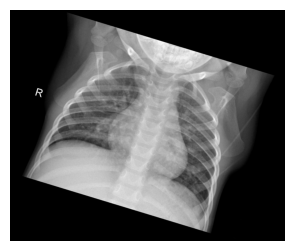

In [24]:
loaded_img = Image.open(dataset_dir / "augmented_sample.jpeg")

loaded_img_as_array = np.asarray(loaded_img)
print(f"Image shape: {loaded_img_as_array.shape}")

plt.figure(figsize=(6, 3))
plt.imshow(loaded_img_as_array, cmap="gray")
plt.axis(False)

#### 1.4.3 Persist transformed images
Looks good. Now let us persist the rest to disk

In [9]:
augmented_dataset_dir = data_path / "chest_xray_2017_augmented/chest_xray"
augmented_train_dir = augmented_dataset_dir / "train"
augmented_test_dir = augmented_dataset_dir / "test"
augmented_dataset_dir, augmented_train_dir, augmented_test_dir

(PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray'),
 PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train'),
 PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/test'))

In [50]:
if not augmented_train_dir.is_dir():
    augmented_train_dir.mkdir(parents=True, exist_ok=True)
if not augmented_test_dir.is_dir():
    augmented_test_dir.mkdir(parents=True, exist_ok=True)

In [10]:
augmented_normal_dir = augmented_train_dir / "NORMAL"
augmented_virus_dir = augmented_train_dir / "VIRAL_PNEUMONIA"
augmented_bacteria_dir = augmented_train_dir / "BACTERIAL_PNEUMONIA"

augmented_normal_test_dir = augmented_test_dir / "NORMAL"
augmented_virus_test_dir = augmented_test_dir / "VIRAL_PNEUMONIA"
augmented_bacteria_test_dir = augmented_test_dir / "BACTERIAL_PNEUMONIA"

In [52]:
import shutil

# Remove existing images if any
if augmented_normal_dir.is_dir():
    shutil.rmtree(augmented_normal_dir)
if augmented_virus_dir.is_dir():
    shutil.rmtree(augmented_virus_dir)
if augmented_bacteria_dir.is_dir():
    shutil.rmtree(augmented_bacteria_dir)

if augmented_normal_dir.is_dir():
    shutil.rmtree(augmented_normal_test_dir)
if augmented_virus_test_dir.is_dir():
    shutil.rmtree(augmented_virus_test_dir)
if augmented_bacteria_test_dir.is_dir():
    shutil.rmtree(augmented_bacteria_test_dir)

In [53]:
if not augmented_normal_dir.is_dir():
    augmented_normal_dir.mkdir(parents=True, exist_ok=True)
if not augmented_virus_dir.is_dir():
    augmented_virus_dir.mkdir(parents=True, exist_ok=True)
if not augmented_bacteria_dir.is_dir():
    augmented_bacteria_dir.mkdir(parents=True, exist_ok=True)  

if not augmented_normal_test_dir.is_dir():
    augmented_normal_test_dir.mkdir(parents=True, exist_ok=True)
if not augmented_virus_test_dir.is_dir():
    augmented_virus_test_dir.mkdir(parents=True, exist_ok=True)
if not augmented_bacteria_test_dir.is_dir():
    augmented_bacteria_test_dir.mkdir(parents=True, exist_ok=True)

First move the existing train images to the augmented directory

In [54]:
from tqdm.auto import tqdm
import shutil
import os

print(f"[INFO] Copying normal images to augmented dir")
for path in tqdm(split_normal_train_paths):
    shutil.copy(path, augmented_normal_dir / os.path.basename(path))

print(f"[INFO] Copying virus images to augmented dir")
for path in tqdm(split_virus_train_paths):
    shutil.copy(path, augmented_virus_dir / os.path.basename(path))

print(f"[INFO] Copying bacteria images to augmented dir")
for path in tqdm(split_bacteria_train_paths):
    shutil.copy(path, augmented_bacteria_dir / os.path.basename(path))

[INFO] Copying normal images to augmented dir


  0%|          | 0/1183 [00:00<?, ?it/s]

[INFO] Copying virus images to augmented dir


  0%|          | 0/1093 [00:00<?, ?it/s]

[INFO] Copying bacteria images to augmented dir


  0%|          | 0/2380 [00:00<?, ?it/s]

In [55]:
print(f"[INFO] Path lengths after moving records:")
print(f"\tNormal: {len(list(augmented_normal_dir.glob('*.jpeg')))}")
print(f"\tVirus: {len(list(augmented_virus_dir.glob('*.jpeg')))}")
print(f"\tBacteria: {len(list(augmented_bacteria_dir.glob('*.jpeg')))}")

[INFO] Path lengths after moving records:
	Normal: 1183
	Virus: 1093
	Bacteria: 2380


In [56]:
print(f"[INFO] Copying normal test images to augmented dir")
for path in tqdm(split_normal_test_paths):
    shutil.copy(path, augmented_normal_test_dir / os.path.basename(path))

print(f"[INFO] Copying virus test images to augmented dir")
for path in tqdm(split_virus_test_paths):
    shutil.copy(path, augmented_virus_test_dir / os.path.basename(path))

print(f"[INFO] Copying bacteria test images to augmented dir")
for path in tqdm(split_bacteria_test_paths):
    shutil.copy(path, augmented_bacteria_test_dir / os.path.basename(path))

[INFO] Copying normal test images to augmented dir


  0%|          | 0/400 [00:00<?, ?it/s]

[INFO] Copying virus test images to augmented dir


  0%|          | 0/400 [00:00<?, ?it/s]

[INFO] Copying bacteria test images to augmented dir


  0%|          | 0/400 [00:00<?, ?it/s]

In [57]:
print(f"[INFO] Test Path lengths after moving records:")
print(f"\tNormal: {len(list(augmented_normal_test_dir.glob('*.jpeg')))}")
print(f"\tVirus: {len(list(augmented_virus_test_dir.glob('*.jpeg')))}")
print(f"\tBacteria: {len(list(augmented_bacteria_test_dir.glob('*.jpeg')))}")

[INFO] Test Path lengths after moving records:
	Normal: 694
	Virus: 400
	Bacteria: 400


We have moved the original images to the respective locations, now augment to fill the count we want.  
We want to increase each category to atleast `5,000` samples

In [61]:
SCALING_LIMIT = 5000
NORMAL_SCALED_COUNT = SCALING_LIMIT - len(split_normal_train_paths)
VIRUS_SCALED_COUNT = SCALING_LIMIT - len(split_virus_train_paths)
BACTERIA_SCALED_COUNT = SCALING_LIMIT - len(split_bacteria_train_paths)

print(f"[INFO] Scaling normal images from {len(split_normal_train_paths)} to {SCALING_LIMIT} by adding {NORMAL_SCALED_COUNT}")
print(f"[INFO] Scaling virus images from {len(split_virus_train_paths)} to {SCALING_LIMIT} by adding {VIRUS_SCALED_COUNT}")
print(f"[INFO] Scaling bacteria images from {len(split_bacteria_train_paths)} to {SCALING_LIMIT} by adding {BACTERIA_SCALED_COUNT}")

[INFO] Scaling normal images from 1183 to 5000 by adding 3817
[INFO] Scaling virus images from 1093 to 5000 by adding 3907
[INFO] Scaling bacteria images from 2380 to 5000 by adding 2620


In [62]:
random.seed(RANDOM_SEED)

print(f"[INFO] Scaling the normal dataset")
for i in tqdm(range(NORMAL_SCALED_COUNT)):
    # Get a random image's path
    rand_path = random.choice(split_normal_train_paths)

    # Load and transform
    rand_img = Image.open(rand_path)
    rand_transformed_image = augmentation_transforms(rand_img)

    # Persist to disk
    torchvision.utils.save_image(rand_transformed_image, fp=augmented_normal_dir / f"normal_augmented_{i}.jpeg")


print(f"[INFO] Scaling the virus dataset")
for i in tqdm(range(VIRUS_SCALED_COUNT)):
    # Get a random image's path
    rand_path = random.choice(split_virus_train_paths)

    # Load and transform
    rand_img = Image.open(rand_path)
    rand_transformed_image = augmentation_transforms(rand_img)

    # Persist to disk
    torchvision.utils.save_image(rand_transformed_image, fp=augmented_virus_dir / f"virus_augmented_{i}.jpeg")


print(f"[INFO] Scaling the bacteria dataset")
for i in tqdm(range(BACTERIA_SCALED_COUNT)):
    # Get a random image's path
    rand_path = random.choice(split_bacteria_train_paths)

    # Load and transform
    rand_img = Image.open(rand_path)
    rand_transformed_image = augmentation_transforms(rand_img)

    # Persist to disk
    torchvision.utils.save_image(rand_transformed_image, fp=augmented_bacteria_dir / f"bacteria_augmented_{i}.jpeg")

performed_augmentation = True

[INFO] Scaling the normal dataset


  0%|          | 0/3817 [00:00<?, ?it/s]

[INFO] Scaling the virus dataset


  0%|          | 0/3907 [00:00<?, ?it/s]

[INFO] Scaling the bacteria dataset


  0%|          | 0/2620 [00:00<?, ?it/s]

We have scaled the datasets, now let's see how many samples we have

In [11]:
augmented_normal_train_paths = list(augmented_train_dir.glob("NORMAL/*.jpeg"))
augmented_virus_train_paths = list(augmented_train_dir.glob("VIRAL_PNEUMONIA/*.jpeg"))
augmented_bacteria_train_paths = list(augmented_train_dir.glob("BACTERIAL_PNEUMONIA/*.jpeg"))

print(f"[INFO] Normal train images (Count: {len(augmented_normal_train_paths)}): \n{augmented_normal_train_paths[:2]}\n")
print(f"[INFO] Virus train images (Count: {len(augmented_virus_train_paths)}): \n{augmented_virus_train_paths[:2]}\n")
print(f"[INFO] Bacteria train images (Count: {len(augmented_bacteria_train_paths)}): \n{augmented_bacteria_train_paths[:2]}\n")

[INFO] Normal train images (Count: 5000): 
[PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train/NORMAL/normal_augmented_1001.jpeg'), PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train/NORMAL/normal_augmented_1383.jpeg')]

[INFO] Virus train images (Count: 5000): 
[PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train/VIRAL_PNEUMONIA/virus_augmented_3570.jpeg'), PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train/VIRAL_PNEUMONIA/virus_augmented_2702.jpeg')]

[INFO] Bacteria train images (Count: 5000): 
[PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train/BACTERIAL_PNEUMONIA/bacteria_augmented_1220.jpeg'), PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train/BACTERIAL_PNEUMONIA/bacteria_augmented_1920.jpeg')]



## 2. EffNetB0 Feature Extractor

In [15]:
# 1. Setup EffNetB0 Weights
effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# 2. Get EffNetB0 transforms
effnetb0_transforms = effnetb0_weights.transforms()

# 3. Setup pretrained model 
effnetb0 = torchvision.models.efficientnet_b0(weights=effnetb0_weights)

for param in effnetb0.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 34.6MB/s]


In [16]:
effnetb0.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Modify the classifier to suit our needs

In [17]:
effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
)

In [12]:
from torchinfo import summary

def get_model_summary(model = nn.Module):
    """Get a summary of the model (uncomment for full output)"""
    return summary(model, 
            input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
    )

In [ ]:
get_model_summary(effnetb0)

### 2.1 Define function for creating an `EffNetB0` Model

In [30]:
def create_effnetb0_model(num_classes:int=3,
                         seed:int=37,
                         compile:bool=True):
    """Creates an EfficientNetB0 Feature Extractor and Transforms"""
    # 1. Setup Weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

    # 2. Get transforms
    transforms = weights.transforms()

    # 3. Setup pretrained model 
    model = torchvision.models.efficientnet_b0(weights=weights)
    model.to(device)

    # 4. Freeze all the layers in the base model
    for param in model.parameters():
        param.requires_grad = False
        
    # 5. Change classifier head with random seed for reproducability
    torch.manual_seed(seed)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=3, bias=True)
    )
    
    if compile:
        model = torch.compile(model)
    
    return model, transforms

In [32]:
effnetb0, effnetb0_transforms = create_effnetb0_model()
get_model_summary(effnetb0)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [32, 3, 224, 224]    [32, 3]              --                   Partial
├─EfficientNet (_orig_mod)                                        --                   --                   --                   Partial
│    └─Sequential (features)                                      --                   --                   (recursive)          False
│    │    └─Conv2dNormActivation (0)                              --                   --                   (recursive)          False
│    │    └─Sequential (1)                                        --                   --                   (recursive)          False
│    │    └─Sequential (2)                                        --                   --                   (recursive)          False
│    │    └─Sequential (3)                     

In [33]:
effnetb0_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 2.2 Create DataLoaders for `EffNetB0`

In [22]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb0, test_dataloader_effnetb0, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb0_transforms,
                                                                                                 batch_size=32)

In [23]:
img, label = next(iter(train_dataloader_effnetb0))
img.shape

torch.Size([32, 3, 224, 224])

### 2.3 Define the train and test functions

In [13]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

### 2.4 Training `EffNetB0` feature extractor

In [25]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb0.parameters(),
                            lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb0_results = train(model=effnetb0,
                                train_dataloader=train_dataloader_effnetb0,
                                test_dataloader=test_dataloader_effnetb0,
                                epochs=NUM_EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

[2023-08-31 02:43:55,854] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-08-31 02:44:29,337] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1 | train_loss: 0.6730 | train_acc: 0.7264 | test_loss: 0.6109 | test_acc: 0.8109
Epoch: 2 | train_loss: 0.5557 | train_acc: 0.7700 | test_loss: 0.6647 | test_acc: 0.7734
Epoch: 4 | train_loss: 0.5162 | train_acc: 0.7778 | test_loss: 0.7642 | test_acc: 0.7359
Epoch: 5 | train_loss: 0.5037 | train_acc: 0.7841 | test_loss: 0.6119 | test_acc: 0.7922
Epoch: 6 | train_loss: 0.4921 | train_acc: 0.7894 | test_loss: 0.6814 | test_acc: 0.7844
Epoch: 7 | train_loss: 0.4906 | train_acc: 0.7872 | test_loss: 0.6459 | test_acc: 0.7797
Epoch: 8 | train_loss: 0.4833 | train_acc: 0.7872 | test_loss: 0.6964 | test_acc: 0.7500
Epoch: 9 | train_loss: 0.4862 | train_acc: 0.7889 | test_loss: 0.6205 | test_acc: 0.7953
Epoch: 10 | train_loss: 0.4760 | train_acc: 0.7995 | test_loss: 0.6717 | test_acc: 0.7797
Epoch: 11 | train_loss: 0.4826 | train_acc: 0.7952 | test_loss: 0.6213 | test_acc: 0.8000
Epoch: 12 | train_loss: 0.4656 | train_acc: 0.7957 | test_loss: 0.6844 | test_acc: 0.7734
Epoch: 13 | train_

### 2.5 Inspect Loss Curves

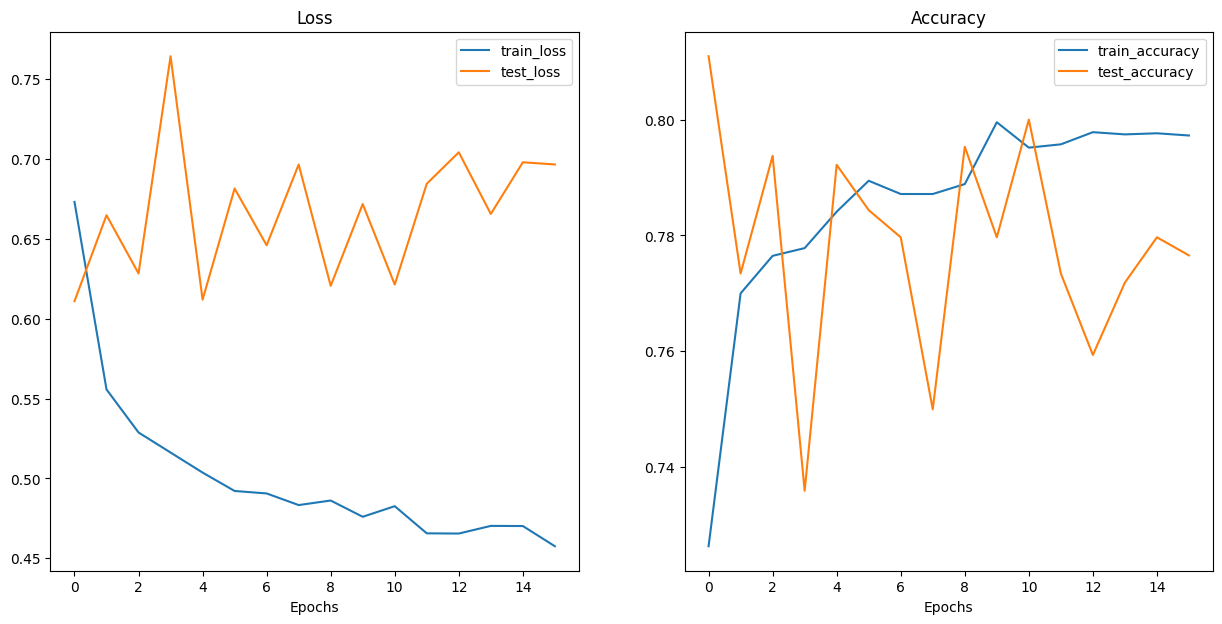

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb0_results)

### 3. With Data Augmentation

In [35]:
effnetb0_trivialaugment, effnetb0_transforms = create_effnetb0_model()

Create dataloaders

In [36]:
augmented_train_dir, augmented_test_dir

(PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/train'),
 PosixPath('/storage/data/chest_xray_2017_augmented/chest_xray/test'))

In [37]:
!ls /storage/data/chest_xray_2017_augmented/chest_xray/train
!ls /storage/data/chest_xray_2017_augmented/chest_xray/test

BACTERIAL_PNEUMONIA  NORMAL  VIRAL_PNEUMONIA
BACTERIAL_PNEUMONIA  NORMAL  VIRAL_PNEUMONIA


In [38]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb0, test_dataloader_effnetb0, class_names = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                                                 test_dir=augmented_test_dir,
                                                                                                 transform=effnetb0_transforms,
                                                                                                 batch_size=32)

Train the model with data augmented datasets

In [39]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb0_trivialaugment.parameters(),
                            lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb0_trivialaugment_results = train(model=effnetb0_trivialaugment,
                                        train_dataloader=train_dataloader_effnetb0,
                                        test_dataloader=test_dataloader_effnetb0,
                                        epochs=NUM_EPOCHS,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

[2023-08-31 18:55:15,272] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-08-31 18:56:34,349] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1 | train_loss: 0.6674 | train_acc: 0.7119 | test_loss: 0.5208 | test_acc: 0.7846
Epoch: 2 | train_loss: 0.5865 | train_acc: 0.7533 | test_loss: 0.5068 | test_acc: 0.7872
Epoch: 3 | train_loss: 0.5653 | train_acc: 0.7614 | test_loss: 0.4910 | test_acc: 0.7949
Epoch: 4 | train_loss: 0.5581 | train_acc: 0.7619 | test_loss: 0.5085 | test_acc: 0.7888
Epoch: 5 | train_loss: 0.5487 | train_acc: 0.7652 | test_loss: 0.4768 | test_acc: 0.8021
Epoch: 6 | train_loss: 0.5493 | train_acc: 0.7671 | test_loss: 0.5425 | test_acc: 0.7878
Epoch: 7 | train_loss: 0.5449 | train_acc: 0.7691 | test_loss: 0.4977 | test_acc: 0.7875
Epoch: 8 | train_loss: 0.5466 | train_acc: 0.7629 | test_loss: 0.5490 | test_acc: 0.7803
Epoch: 9 | train_loss: 0.5588 | train_acc: 0.7623 | test_loss: 0.4809 | test_acc: 0.7938
Epoch: 10 | train_loss: 0.5541 | train_acc: 0.7646 | test_loss: 0.5029 | test_acc: 0.7888
Epoch: 11 | train_loss: 0.5462 | train_acc: 0.7696 | test_loss: 0.5296 | test_acc: 0.7914
Epoch: 12 | train_l

Inspect loss curves

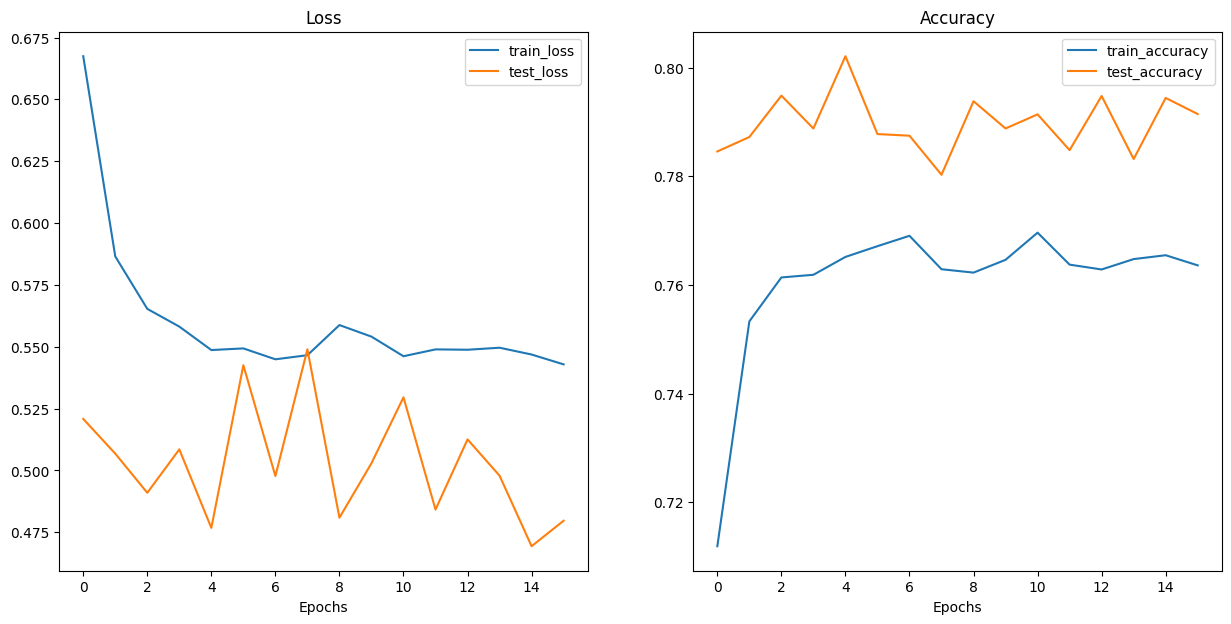

In [41]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb0_trivialaugment_results)

### 4. Fine Tune `EffNetb0`

In [35]:
# Create the model and transforms
effnetb0_finetune, effnetb0_transforms_finetune = create_effnetb0_model(compile=False)

In [36]:
for name, child in effnetb0_finetune.named_children():
    print(f"Layer Name; {name}")

Layer Name; features
Layer Name; avgpool
Layer Name; classifier


In [37]:
for name, child in effnetb0_finetune.named_children():
    if name in ['features']:
        print(f"[INFO] Unfreezing layer: {name}")
        for param in child.parameters():
            param.requires_grad = True

[INFO] Unfreezing layer: features


In [38]:
get_model_summary(effnetb0_finetune)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [41]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb0_ft, test_dataloader_effnetb0_ft, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb0_transforms_finetune,
                                                                                                 batch_size=32)

In [42]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb0_finetune.parameters(),
                            lr=1e-4, weight_decay=2e-05)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb0_finetune_results = train(model=effnetb0_finetune,
                                train_dataloader=train_dataloader_effnetb0_ft,
                                test_dataloader=test_dataloader_effnetb0_ft,
                                epochs=NUM_EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3118 | train_acc: 0.8746 | test_loss: 0.2849 | test_acc: 0.8984
Epoch: 2 | train_loss: 0.1766 | train_acc: 0.9352 | test_loss: 0.3068 | test_acc: 0.8969
Epoch: 3 | train_loss: 0.1234 | train_acc: 0.9581 | test_loss: 0.2848 | test_acc: 0.8906
Epoch: 4 | train_loss: 0.0978 | train_acc: 0.9653 | test_loss: 0.3916 | test_acc: 0.8750
Epoch: 5 | train_loss: 0.0891 | train_acc: 0.9691 | test_loss: 0.3719 | test_acc: 0.8750
Epoch: 6 | train_loss: 0.0587 | train_acc: 0.9808 | test_loss: 0.3698 | test_acc: 0.8875
Epoch: 7 | train_loss: 0.0495 | train_acc: 0.9823 | test_loss: 0.3336 | test_acc: 0.8938
Epoch: 8 | train_loss: 0.0475 | train_acc: 0.9844 | test_loss: 0.3748 | test_acc: 0.8859
Epoch: 9 | train_loss: 0.0488 | train_acc: 0.9827 | test_loss: 0.4443 | test_acc: 0.8781
Epoch: 10 | train_loss: 0.0320 | train_acc: 0.9903 | test_loss: 0.4963 | test_acc: 0.8766
Epoch: 11 | train_loss: 0.0365 | train_acc: 0.9872 | test_loss: 0.4966 | test_acc: 0.8641
Epoch: 12 | train_l

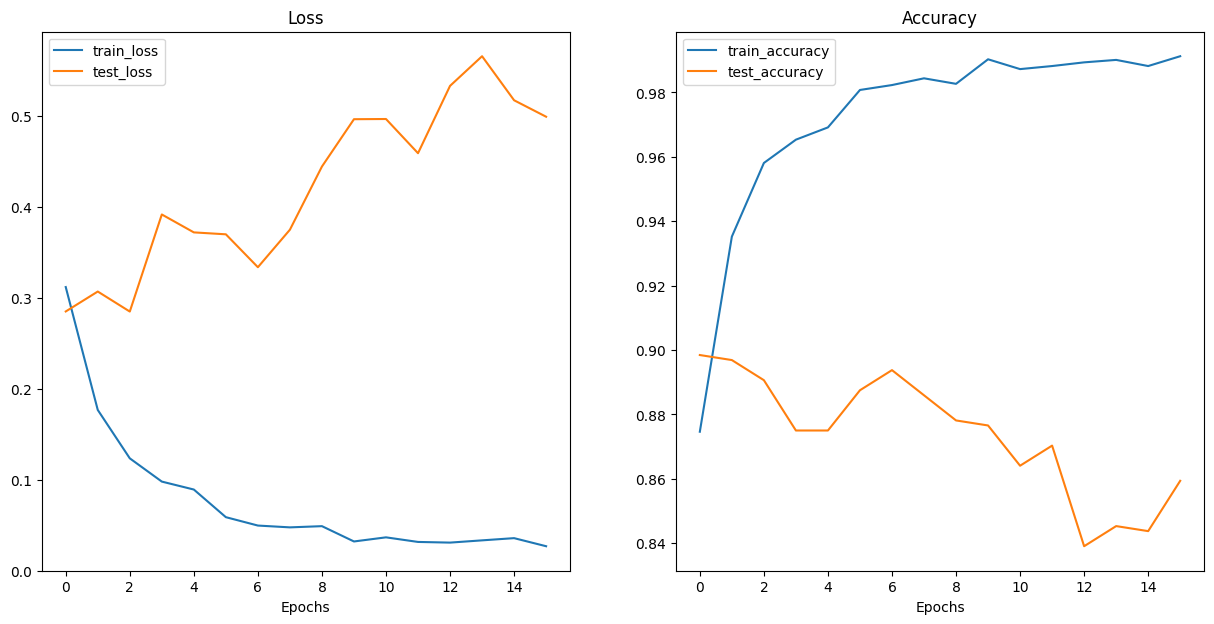

In [43]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb0_finetune_results)

### 4.2 Fine Tune `EffNetb0` with Augmented Data

In [50]:
# Create the model and transforms
effnetb0_finetune_augment, effnetb0_transforms_finetune_augment = create_effnetb0_model(compile=False)

for name, child in effnetb0_finetune_augment.named_children():
    print(f"Layer Name; {name}")

Layer Name; features
Layer Name; avgpool
Layer Name; classifier


In [51]:
for name, child in effnetb0_finetune_augment.named_children():
    if name in ['features']:
        print(f"[INFO] Unfreezing layer: {name}")
        for param in child.parameters():
            param.requires_grad = True

[INFO] Unfreezing layer: features


In [52]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb0_ft_ag, test_dataloader_effnetb0_ft_ag, class_names = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                                                 test_dir=augmented_test_dir,
                                                                                                 transform=effnetb0_transforms_finetune_augment,
                                                                                                 batch_size=32)

In [53]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb0_finetune_augment.parameters(),
                            lr=1e-5, weight_decay=2e-05)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb0_finetune_augment_results = train(model=effnetb0_finetune_augment,
                                train_dataloader=train_dataloader_effnetb0_ft_ag,
                                test_dataloader=test_dataloader_effnetb0_ft_ag,
                                epochs=NUM_EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8045 | train_acc: 0.6602 | test_loss: 0.5340 | test_acc: 0.7750
Epoch: 2 | train_loss: 0.5463 | train_acc: 0.7779 | test_loss: 0.4633 | test_acc: 0.8089
Epoch: 3 | train_loss: 0.4715 | train_acc: 0.8035 | test_loss: 0.4283 | test_acc: 0.8185
Epoch: 4 | train_loss: 0.4339 | train_acc: 0.8196 | test_loss: 0.4311 | test_acc: 0.8169
Epoch: 5 | train_loss: 0.3991 | train_acc: 0.8340 | test_loss: 0.4093 | test_acc: 0.8251
Epoch: 6 | train_loss: 0.3778 | train_acc: 0.8401 | test_loss: 0.4002 | test_acc: 0.8258
Epoch: 7 | train_loss: 0.3491 | train_acc: 0.8559 | test_loss: 0.4078 | test_acc: 0.8265
Epoch: 8 | train_loss: 0.3284 | train_acc: 0.8667 | test_loss: 0.4135 | test_acc: 0.8231
Epoch: 9 | train_loss: 0.3117 | train_acc: 0.8728 | test_loss: 0.3914 | test_acc: 0.8393
Epoch: 10 | train_loss: 0.2876 | train_acc: 0.8840 | test_loss: 0.3991 | test_acc: 0.8386
Epoch: 11 | train_loss: 0.2678 | train_acc: 0.8909 | test_loss: 0.3996 | test_acc: 0.8453
Epoch: 12 | train_l

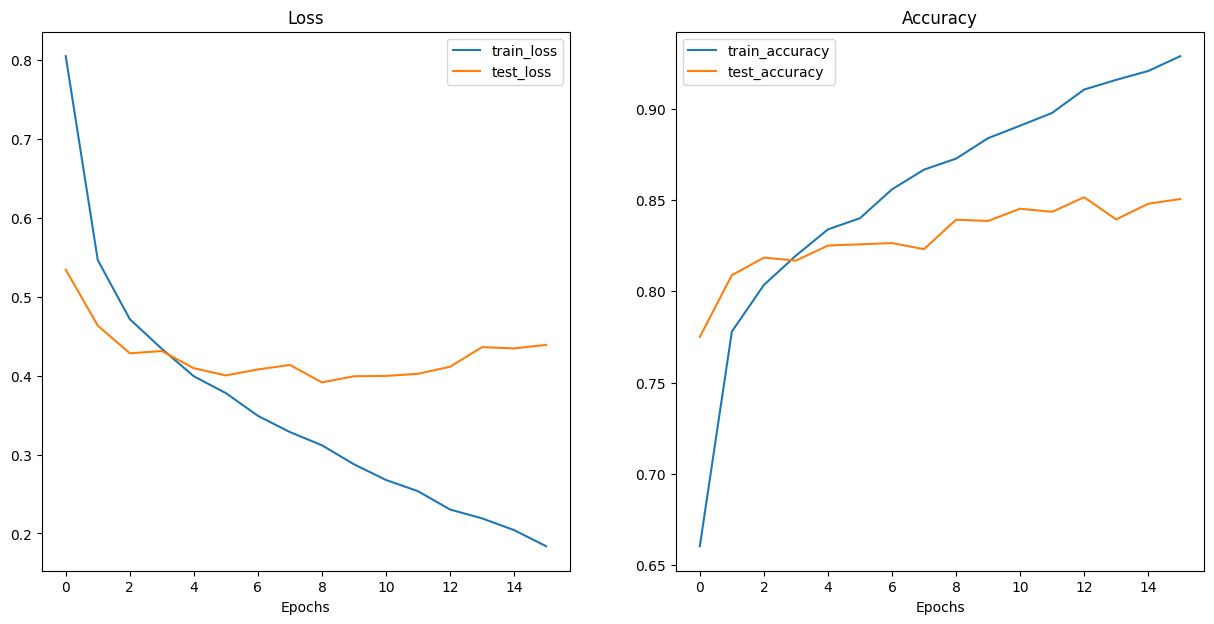

In [54]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb0_finetune_augment_results)

## 5. EffNetB2 Model

In [37]:
# 1. Setup EffNetB0 Weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB0 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model 
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

get_model_summary(effnetb2)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16

### 5.1 Define function for creating EffNetB2 Model

In [38]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [14]:
def create_effnetb2_model(num_classes:int=3,
                         seed:int=37,
                         compile:bool=False):
    """Creates an EfficientNetB2 Feature Extractor and Transforms"""
    # 1. Setup Weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

    # 2. Get transforms
    transforms = weights.transforms()

    # 3. Setup pretrained model 
    model = torchvision.models.efficientnet_b2(weights=weights)
    model.to(device)

    # 4. Freeze all the layers in the base model
    for param in model.parameters():
        param.requires_grad = False
        
    # 5. Change classifier head with random seed for reproducability
    torch.manual_seed(seed)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=3, bias=True)
    )
    
    if compile:
        model = torch.compile(model)
    
    return model, transforms

In [40]:
effnetb2, effnetb2_transforms = create_effnetb2_model()
get_model_summary(effnetb2)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 5.2 Create `EffNetB2` Data Loaders

In [56]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### 5.3 Training `EffNetB2` Feature Extractor

In [58]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                            lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb2_results = train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=NUM_EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5724 | train_acc: 0.7710 | test_loss: 0.6106 | test_acc: 0.7859
Epoch: 2 | train_loss: 0.5415 | train_acc: 0.7763 | test_loss: 0.6551 | test_acc: 0.7688
Epoch: 3 | train_loss: 0.5296 | train_acc: 0.7769 | test_loss: 0.6267 | test_acc: 0.7922
Epoch: 4 | train_loss: 0.5186 | train_acc: 0.7769 | test_loss: 0.7034 | test_acc: 0.7766
Epoch: 5 | train_loss: 0.5080 | train_acc: 0.7805 | test_loss: 0.6057 | test_acc: 0.7953
Epoch: 6 | train_loss: 0.5000 | train_acc: 0.7910 | test_loss: 0.6552 | test_acc: 0.7859
Epoch: 7 | train_loss: 0.4992 | train_acc: 0.7912 | test_loss: 0.6662 | test_acc: 0.7812
Epoch: 8 | train_loss: 0.4954 | train_acc: 0.7862 | test_loss: 0.6649 | test_acc: 0.7781
Epoch: 9 | train_loss: 0.4893 | train_acc: 0.7955 | test_loss: 0.6505 | test_acc: 0.7844
Epoch: 10 | train_loss: 0.4819 | train_acc: 0.7992 | test_loss: 0.6732 | test_acc: 0.7766
Epoch: 11 | train_loss: 0.4850 | train_acc: 0.7973 | test_loss: 0.6520 | test_acc: 0.7797
Epoch: 12 | train_l

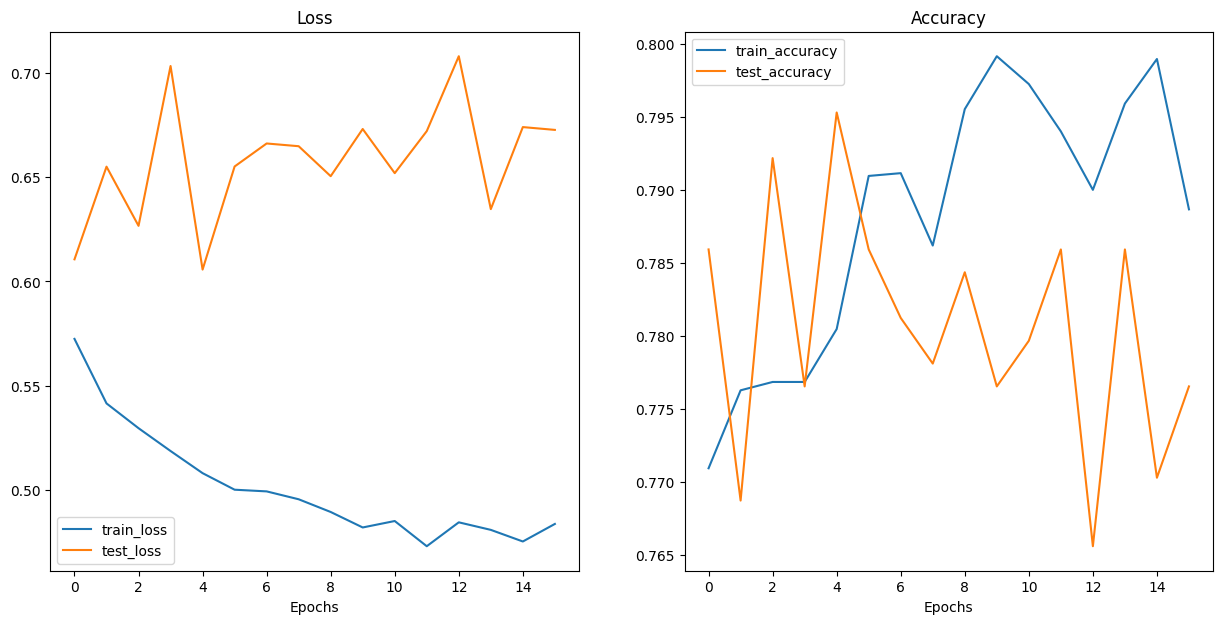

In [59]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 5.4 `EffNetB2` With Augmented data

#### 5.4.1 Train the model

In [15]:
effnetb2_augmented, effnetb2_augmented_transforms = create_effnetb2_model()
get_model_summary(effnetb2_augmented)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 317MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [16]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2_augmented, test_dataloader_effnetb2_augmented, class_names = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                                                 test_dir=augmented_test_dir,
                                                                                                 transform=effnetb2_augmented_transforms,
                                                                                                 batch_size=32)

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_augmented.parameters(),
                            lr=1e-5)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb2_augmented_results = train(model=effnetb2_augmented,
                                train_dataloader=train_dataloader_effnetb2_augmented,
                                test_dataloader=test_dataloader_effnetb2_augmented,
                                epochs=NUM_EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0918 | train_acc: 0.3704 | test_loss: 1.0657 | test_acc: 0.4564
Epoch: 2 | train_loss: 1.0300 | train_acc: 0.5082 | test_loss: 1.0146 | test_acc: 0.5956
Epoch: 3 | train_loss: 0.9762 | train_acc: 0.5946 | test_loss: 0.9802 | test_acc: 0.6139
Epoch: 4 | train_loss: 0.9339 | train_acc: 0.6328 | test_loss: 0.9394 | test_acc: 0.6491
Epoch: 5 | train_loss: 0.8957 | train_acc: 0.6638 | test_loss: 0.9084 | test_acc: 0.6637
Epoch: 6 | train_loss: 0.8653 | train_acc: 0.6770 | test_loss: 0.8811 | test_acc: 0.6691
Epoch: 7 | train_loss: 0.8367 | train_acc: 0.6863 | test_loss: 0.8520 | test_acc: 0.6844
Epoch: 8 | train_loss: 0.8145 | train_acc: 0.7006 | test_loss: 0.8405 | test_acc: 0.6664
Epoch: 9 | train_loss: 0.7972 | train_acc: 0.6963 | test_loss: 0.8091 | test_acc: 0.6920
Epoch: 10 | train_loss: 0.7769 | train_acc: 0.7043 | test_loss: 0.7904 | test_acc: 0.6963
Epoch: 11 | train_loss: 0.7594 | train_acc: 0.7138 | test_loss: 0.7727 | test_acc: 0.7106
Epoch: 12 | train_l

#### 5.4.2 View Results

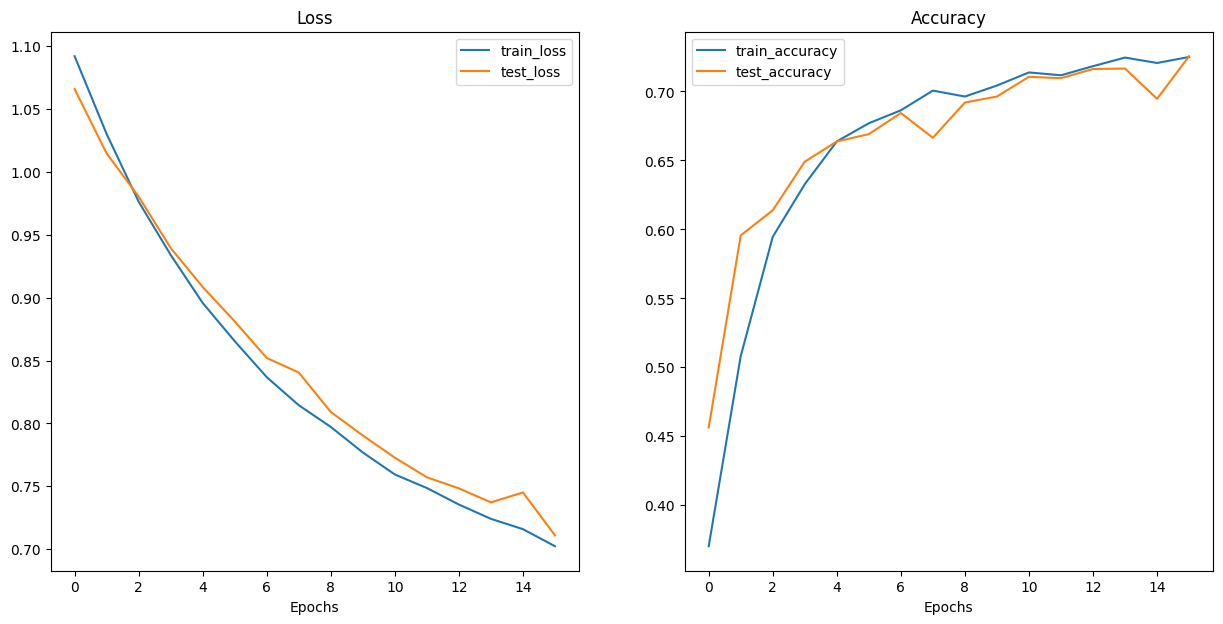

In [19]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_augmented_results)

### 5.5 `EffNetB2` Finetuned & With Augmented data

#### 5.5.1 Create and Train Model

In [27]:
effnetb2_ft_ag, effnetb2_ft_ag_transforms = create_effnetb2_model()
get_model_summary(effnetb2_ft_ag)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
# finetune the features layer
for name, child in effnetb2_ft_ag.named_children():
    if name in ['features']:
        print(f"[INFO] Unfreezing layer: {name}")
        for param in child.parameters():
            param.requires_grad = True
get_model_summary(effnetb2_ft_ag)

[INFO] Unfreezing layer: features


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [29]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2_ft_ag, test_dataloader_effnetb2_ft_ag, class_names = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                                                 test_dir=augmented_test_dir,
                                                                                                 transform=effnetb2_ft_ag_transforms,
                                                                                                 batch_size=32)

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_ft_ag.parameters(),
                            lr=1e-6,
                            weight_decay=2e-07)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 16

# Set seeds for reproducability and train the model
set_seeds()
effnetb2_ft_ag_results = train(model=effnetb2_ft_ag,
                                train_dataloader=train_dataloader_effnetb2_ft_ag,
                                test_dataloader=test_dataloader_effnetb2_ft_ag,
                                epochs=NUM_EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0832 | train_acc: 0.3941 | test_loss: 1.0559 | test_acc: 0.4518
Epoch: 2 | train_loss: 0.9936 | train_acc: 0.5663 | test_loss: 0.9652 | test_acc: 0.6147
Epoch: 3 | train_loss: 0.9000 | train_acc: 0.6617 | test_loss: 0.8744 | test_acc: 0.6595
Epoch: 4 | train_loss: 0.8141 | train_acc: 0.7021 | test_loss: 0.7463 | test_acc: 0.7027
Epoch: 5 | train_loss: 0.7384 | train_acc: 0.7302 | test_loss: 0.6695 | test_acc: 0.7173
Epoch: 6 | train_loss: 0.6847 | train_acc: 0.7409 | test_loss: 0.6221 | test_acc: 0.7286
Epoch: 7 | train_loss: 0.6405 | train_acc: 0.7532 | test_loss: 0.5835 | test_acc: 0.7508
Epoch: 8 | train_loss: 0.6119 | train_acc: 0.7592 | test_loss: 0.5686 | test_acc: 0.7577
Epoch: 9 | train_loss: 0.5928 | train_acc: 0.7652 | test_loss: 0.5288 | test_acc: 0.7793
Epoch: 10 | train_loss: 0.5655 | train_acc: 0.7712 | test_loss: 0.5161 | test_acc: 0.7809
Epoch: 11 | train_loss: 0.5494 | train_acc: 0.7810 | test_loss: 0.5015 | test_acc: 0.7906
Epoch: 12 | train_l

#### 5.5.2 View Results

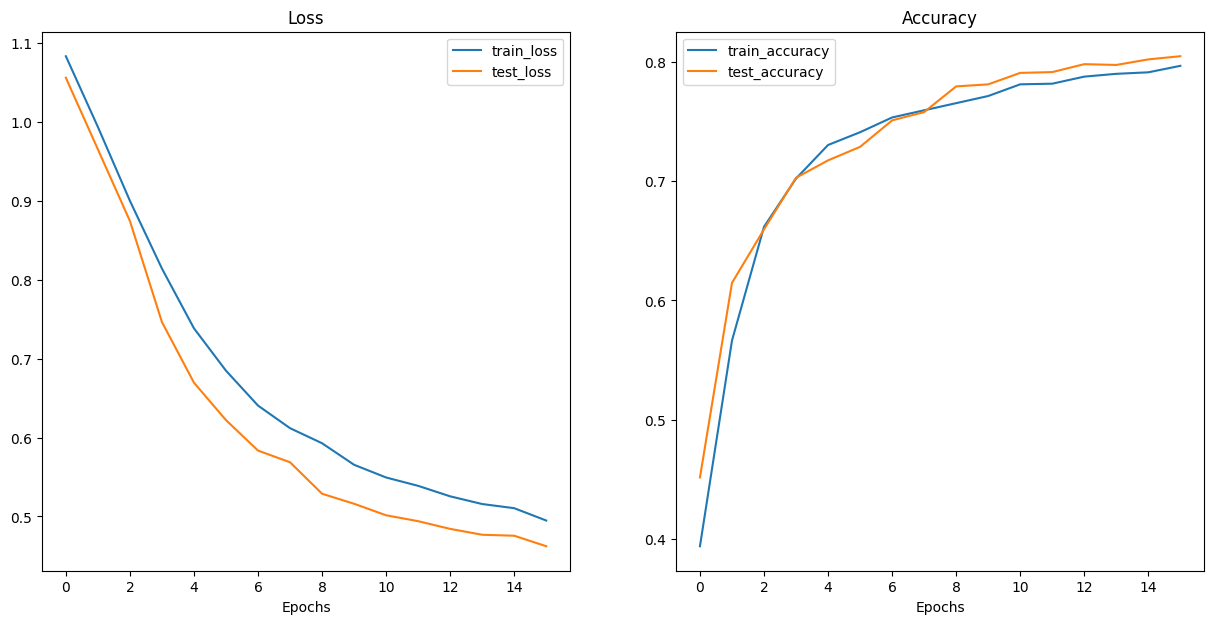

In [30]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_ft_ag_results)